In [175]:
import torch
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from modules.fem_module import FiniteElement1D

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [176]:
torch.manual_seed(43)
np.random.seed(43)

In [177]:
print(torch.__version__)

2.9.1+cu130


In [178]:
!nvidia-smi

Tue Jan 20 11:31:34 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650        On  |   00000000:01:00.0  On |                  N/A |
| 40%   38C    P5            N/A  /   75W |     620MiB /   4096MiB |     21%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [179]:
class FullyConnected(torch.nn.Module):
    def __init__(self, n_hidden, n_layer):
        super(FullyConnected, self).__init__()
        self.hidden1 = torch.nn.Linear(1, n_hidden).double().to(device)
        torch.nn.init.xavier_uniform_(self.hidden1.weight, gain=1).to(device)
        torch.nn.init.ones_(self.hidden1.bias).to(device)

        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden).double().to(device)    # hidden layer
        torch.nn.init.xavier_uniform_(self.hidden2.weight, gain=1).to(device)
        torch.nn.init.ones_(self.hidden2.bias).to(device)

        self.predict = torch.nn.Linear(n_hidden, 1).double().to(device)   # output layer
        torch.nn.init.xavier_uniform_(self.predict.weight, gain=1).to(device)
        torch.nn.init.ones_(self.predict.bias).to(device)

        self.bn1 = torch.nn.BatchNorm1d(num_features=n_hidden).double().to(device)

        self.num_layers = n_layer
        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()

        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x, train=False):
        x = self.hidden1(x)
        # x = self.bn1(x)
        x = self.tanh(x)
        # x = self.dropout(x)

        # for creating number of layers dynamically
        for _ in range(self.num_layers):
            x = self.hidden2(x)
            # x = self.bn1(x)
            x = self.tanh(x)
            # x = self.dropout(x)
        x = self.predict(x)
        return x

In [180]:
def get_der(u, t, order=2):
    # calculating derivation using AD
    
    # Calcula primeira derivada
    du = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]
    
    if du is None:
        return torch.zeros_like(t, requires_grad=True)
    
    # Calcula segunda derivada se necessário
    if order >= 2:
        d2u = torch.autograd.grad(du, t, grad_outputs=torch.ones_like(du), create_graph=True, allow_unused=True)[0]
        if d2u is None:
            return torch.zeros_like(t, requires_grad=True)
        return d2u
    
    return du

def loss_f(u, t, f, order=2):
    # u, t, f are in (number_of_samples,1) shape. Residue for: -u'' = f → u'' + f = 0
    
    d2u = get_der(u, t, order) # Calcula a segunda derivada
    
    # Garante que f tem a mesma forma que t
    if isinstance(f, (int, float)):
        f = torch.full_like(t, f)
    elif f.shape != t.shape:
        f = f.reshape(-1, 1) if len(f.shape) == 1 else f
        if f.shape[0] != t.shape[0]:
            # Se f for um único valor, repete para todos os pontos
            if f.numel() == 1:
                f = f.repeat(t.shape[0], 1)
            else:
                raise ValueError(f'Dimensão de f ({f.shape[0]}) não corresponde a t ({t.shape[0]})')
    
    residual = d2u + f    # Resíduo: u'' + f (porque -u'' = f → u'' + f = 0)
    
    return torch.mean(residual**2) # Retorna MSE do resíduo

def loss_mse(left, lv, right, rv, model):
    x_bc = torch.tensor([[left], [right]], dtype=torch.double, device=device)
    y_bc = torch.tensor([[lv], [rv]], dtype=torch.double, device=device)

    u_pred = model(x_bc)
    l = torch.mean((u_pred - y_bc)**2)
    return l

def loss_fem(A, F, u):
    residuo = torch.matmul(torch.tensor(A).to(device), u)-torch.tensor(F).to(device)
    l = torch.norm(residuo, p=2)
    return l

In [181]:
# This file contain different training methods for neural network. e.g.: train pinn alone, train pinn and fem together etc

class train_model_base():
    def __init__(self, model):
        self.model = model.to(device)
        self.train_data = None

    def _calculate_loss(self, u):
        pass

    def train(self, data, epochs=1000, opt=None):
        self.train_data = data.to(device)
        self.model.train()
        if opt is None:
            opt = torch.optim.Adam(self.model.parameters(), lr = 0.0003)
        self.loss_h = []
        for epoch in range(epochs):
            u = self.model(self.train_data)
            loss_epoch = self._calculate_loss(u)
            opt.zero_grad()
            loss_epoch.backward()
            opt.step()
            if epoch % 1000 == 0:
                print(epoch, loss_epoch.detach().cpu().numpy())
            self.loss_h.append(loss_epoch.detach().cpu().numpy())
        return self.loss_h

    def predict(self, p_in_data):
        self.model.eval()
        with torch.inference_mode():
            prediction = self.model(p_in_data)
        return prediction

    def plot_training(self):
        plt.plot(self.loss_h)

class train_pinn_1d(train_model_base):
    def __init__(self, model, f, l_bc, r_bc):
        train_model_base.__init__(self, model)
        self.force = f
        self.left_bc = l_bc
        self.right_bc = r_bc
    def _calculate_loss(self, u):
        l = loss_f(u, self.train_data, self.force) + loss_mse(0.0, self.left_bc, 2.0, self.right_bc, self.model)
        return l

class train_fem_loss_1d(train_model_base):
    def __init__(self, model, A, F):
        train_model_base.__init__(self, model)
        self.A = A
        self.F = F
    def _calculate_loss(self, u):
        l = loss_fem(self.A, self.F, u)
        return l

In [182]:
def plot_data(np_array1=None, np_array2=None, np_array3=None, savefile_name=None, labels=None):
    plt.figure(figsize=(9, 6))

    Var1X, Var1Y = np_array1[:, 0], np_array1[:, 1]
    Var2X, Var2Y = np_array2[:, 0], np_array2[:, 1]
    Var3X, Var3Y = np_array3[:, 0], np_array3[:, 1]

    x_min, x_max = np.min(Var3X), np.max(Var3X)
    y_min, y_max = np.min(Var3Y), np.max(Var3Y)

    plt.plot(Var1X, Var1Y, label=labels[0], ls='dashed', marker='s', ms=5, c='blue')
    plt.plot(Var2X, Var2Y, label=labels[1], ls='solid', marker='*', ms=5, c='red')
    plt.plot(Var3X, Var3Y, label=labels[2], ls='solid', marker='p', ms=5, c='green')

    print('Limits are ', x_min, x_max, y_min, y_max)

    plt.xlabel(labels[3])
    plt.ylabel(labels[4])
    plt.grid(ls='--', alpha=0.5, c='#ccc')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'img/fem_nn/{savefile_name}.pdf', dpi=300, bbox_inches='tight', format='pdf')
    plt.show()
    plt.close()

In [183]:
def plot_loss(loss_1, loss_2, nome_arquivo):
    plt.plot(loss_1, label='Train Loss PINN', c='blue')
    plt.plot(loss_2, label='Train Loss FEM-NN', c='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.tight_layout()
    # plt.savefig(f'img/fem_nn/{nome_arquivo}.pdf', dpi=300, bbox_inches='tight', format='pdf')
    plt.show()

# Usando pontos nodais do FEM como pontos de colocação para PINN

\begin{align*}
    &-u''(x) = f(x), \\
    &u(0) = a, u(2) = b.
\end{align*}

Um exemplo simples de Poisson é testado com PINN combinado com função perda baseada em FEM.

## Iniciando o caso polinomial: $ f(x) = 6(x-1)^{5} + 2(x-1) $

In [184]:
l_bc, r_bc = 10/21, -10/21              # Condições de contorno

# Definição da fonte externa
def f(x): return 6*(x-1)**5 + 2*(x-1)

# Solução exata
def sol_exata(x): return -((x-1)**7)/7 - ((x-1)**3)/3

modelo_fem = FiniteElement1D()          # Definindo modelo de elementos finitos em 1D

[a, b] = [0, 2]                         # Definição do domínio
nint, nen = (2, 2)                      # número de pontos de integração, número de elmentos nodais
nel = 9                                 # número de elementos no domínio
nodes_d = (nen-1)*nel+1                 # número total de nós

# Criando matrizes para função perda baseada em FEM
A, F = modelo_fem.make_matrices(f, a, b, nel, nint, nen, l_bc, r_bc)
F = F.reshape(-1, 1)

In [185]:
model_1 = FullyConnected(10, 3).to(device)
# Copiando modelo para ter a mesma inicialização para ambos os modelos
model_2 = copy.deepcopy(model_1)
model_3 = copy.deepcopy(model_1)
model_4 = copy.deepcopy(model_1)

In [186]:
data_fem = torch.linspace(0, 2, nodes_d).reshape(-1, 1).requires_grad_(True).double().to(device)

In [187]:
force = 6*(data_fem-1)**5 + 2*(data_fem-1)
force = force.detach().clone().requires_grad_(True).to(device)

epoch = 1900

In [188]:
# Treino usando PINN
pinn_trainer = train_pinn_1d(model_1, force, l_bc, r_bc)
loss_1 = pinn_trainer.train(data_fem, epochs=epoch)

0 17.309236198109193
1000 6.348656332037125


In [189]:
# Treino usando FEM-NN
fem_loss_trainer = train_fem_loss_1d(model_2, A, F)
loss_2 = fem_loss_trainer.train(data_fem, epochs=epoch)

0 2.3286881807466453
1000 1.081356064961705


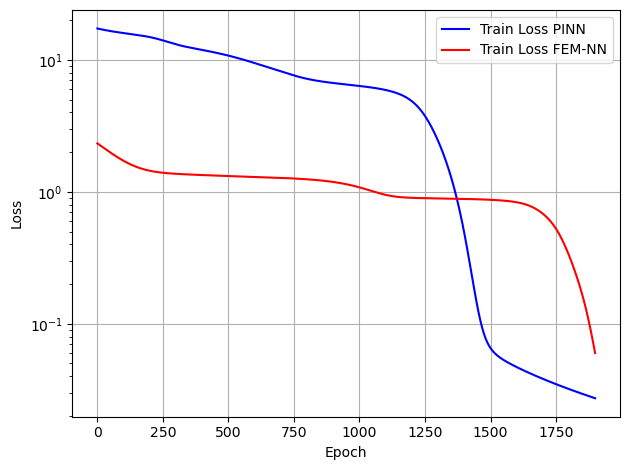

In [190]:
nome_arquivo = f'dataset1_simples_loss_{epoch}'
plot_loss(loss_1, loss_2, nome_arquivo)

In [191]:
# Predições
test_in = torch.linspace(0, 2, 129).reshape(-1, 1).to(device)
u_exata = np.asarray([sol_exata(x) for x in test_in.detach().cpu().numpy()])

test_out_1 = pinn_trainer.predict(test_in.double())
test_out_2 = fem_loss_trainer.predict(test_in.double())

In [192]:
# Métricas PINN
mse_pinn = mean_squared_error(u_exata, test_out_1.detach().cpu().numpy())
mae_pinn = mean_absolute_error(u_exata, test_out_1.detach().cpu().numpy())
r2_pinn = r2_score(u_exata, test_out_1.detach().cpu().numpy())
rel_err_pinn = np.linalg.norm(u_exata - test_out_1.detach().cpu().numpy())/np.linalg.norm(u_exata)

In [193]:
# Métricas FEM-NN
mse_femnn = mean_squared_error(u_exata, test_out_2.detach().cpu().numpy())
mae_femnn = mean_absolute_error(u_exata, test_out_2.detach().cpu().numpy())
r2_femnn = r2_score(u_exata, test_out_2.detach().cpu().numpy())
rel_err_femnn = np.linalg.norm(u_exata - test_out_2.detach().cpu().numpy())/np.linalg.norm(u_exata)

In [194]:
metrics_summary = (
    {'Modelo': 'PINN', 'MSE': mse_pinn, 'MAE': mae_pinn, 'ER': rel_err_pinn, 'R2': r2_pinn},
    {'Modelo': 'FEM-NN', 'MSE': mse_femnn, 'MAE': mae_femnn, 'ER': rel_err_femnn, 'R2': r2_femnn}
)

results = pd.DataFrame(metrics_summary)
print(results[['Modelo', 'MSE', 'MAE', 'ER', 'R2']])

   Modelo      MSE       MAE        ER        R2
0    PINN  0.00112  0.028224  0.201846  0.959258
1  FEM-NN  0.00039  0.017673  0.119145  0.985804


Limits are  0.0 2.0 -0.4761905 0.4761905


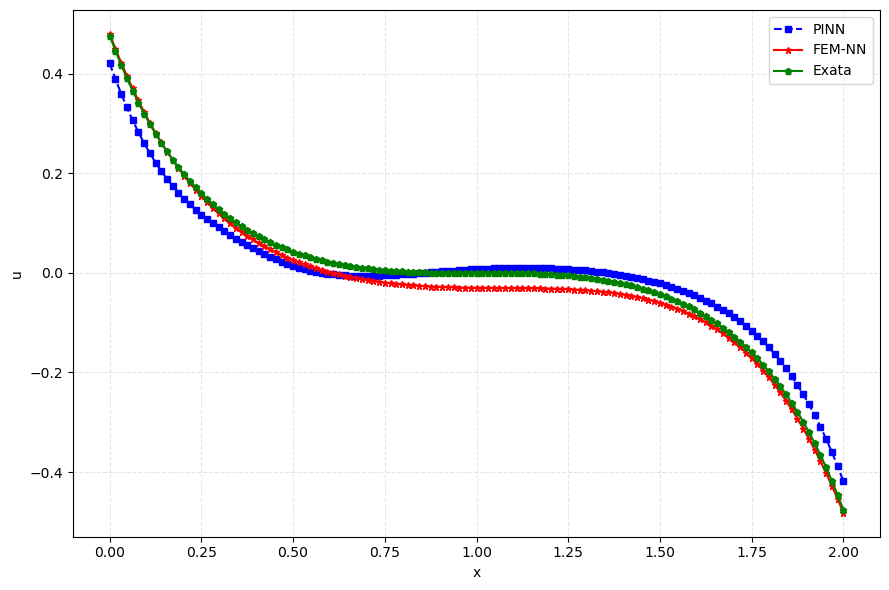

In [195]:
var1 = np.concatenate((test_in.detach().cpu().numpy(), test_out_1.detach().cpu().numpy()), axis=1)
var2 = np.concatenate((test_in.detach().cpu().numpy(), test_out_2.detach().cpu().numpy()), axis=1)
var3 = np.concatenate((test_in.detach().cpu().numpy(), u_exata), axis=1)

plot_data(var1, var2, var3, f'dataset1_simples_{epoch}', ['PINN', 'FEM-NN', 'Exata', 'x', 'u'])

# Iniciando o caso oscilatório $f(x) = -2\pi^{2}\cos(2\pi x)$

In [196]:
l_bc, r_bc = 0, 0                   # Condições de contorno

# Definição da fonte externa
def f(x): return -2*(np.pi**2)*np.cos(2*np.pi*x)

# Solução exata
def sol_exata(x): return np.sin(np.pi*x)**2

modelo_fem = FiniteElement1D()      # Definindo modelo de elementos finitos em 1D

[a, b] = [0, 2]                     # Definição do domínio
nint, nen = (5, 5)                  # número de pontos de integração, número de elmentos nodais
nel = 9
nodes_d = (nen-1)*nel+1             # número total de nós

# Criando matrizes para função perda baseada em FEM
A2, F2 = modelo_fem.make_matrices(f, a, b, nel, nint, nen, l_bc, r_bc)
F2 = F2.reshape(-1, 1)

In [197]:
data_fem = torch.linspace(0, 2, nodes_d).reshape(-1, 1).requires_grad_(True).double().to(device)

In [198]:
force = -2*(torch.pi**2)*torch.cos(2*torch.pi*data_fem)
force = force.detach().clone().requires_grad_(True).to(device)

epoch = 3000

In [199]:
# Treino usando PINN
pinn_trainer = train_pinn_1d(model_3, force, l_bc, r_bc)
loss_1 = pinn_trainer.train(data_fem, epochs=epoch)

0 201.7878693505472
1000 87.14878070095229
2000 5.094527091736778


In [200]:
# Treino usando FEM-NN
fem_loss_trainer = train_fem_loss_1d(model_4, A2, F2)
loss_2 = fem_loss_trainer.train(data_fem, epochs=epoch)

0 5.236354767276446
1000 4.898716827674134
2000 2.3207373419001645


In [201]:
torch.save(model_4.state_dict(), 'modelo_femnn.pt') # Salvando o modelo FEM-NN

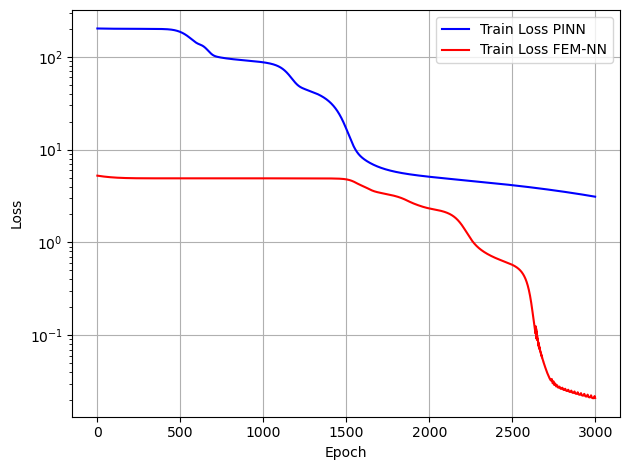

In [202]:
nome_arquivo = f'dataset1_simples_loss_{epoch}'
plot_loss(loss_1, loss_2, nome_arquivo)

In [203]:
# Predições
test_in = torch.linspace(0, 2, 129).reshape(-1, 1).double().to(device)
u_exata = np.asarray([sol_exata(x) for x in test_in.detach().cpu().numpy()])

test_out_1 = pinn_trainer.predict(test_in.double())
test_out_2 = fem_loss_trainer.predict(test_in.double())

In [204]:
# Métricas PINN
mse_pinn = mean_squared_error(u_exata, test_out_1.detach().cpu().numpy())
mae_pinn = mean_absolute_error(u_exata, test_out_1.detach().cpu().numpy())
r2_pinn = r2_score(u_exata, test_out_1.detach().cpu().numpy())
rel_err_pinn = np.linalg.norm(u_exata - test_out_1.detach().cpu().numpy())/np.linalg.norm(u_exata)

In [205]:
# Métricas FEM-NN
mse_femnn = mean_squared_error(u_exata, test_out_2.detach().cpu().numpy())
mae_femnn = mean_absolute_error(u_exata, test_out_2.detach().cpu().numpy())
r2_femnn = r2_score(u_exata, test_out_2.detach().cpu().numpy())
rel_err_femnn = np.linalg.norm(u_exata - test_out_2.detach().cpu().numpy())/np.linalg.norm(u_exata)

In [206]:
metrics_summary = (
    {'Modelo': 'PINN', 'MSE': mse_pinn, 'MAE': mae_pinn, 'ER': rel_err_pinn, 'R2': r2_pinn},
    {'Modelo': 'FEM-NN', 'MSE': mse_femnn, 'MAE': mae_femnn, 'ER': rel_err_femnn, 'R2': r2_femnn}
)

results = pd.DataFrame(metrics_summary)
print(results[['Modelo', 'MSE', 'MAE', 'ER', 'R2']])

   Modelo       MSE       MAE        ER        R2
0    PINN  0.345737  0.525934  0.963934 -1.744950
1  FEM-NN  0.000003  0.001466  0.002846  0.999976


Limits are  0.0 2.0 0.0 1.0


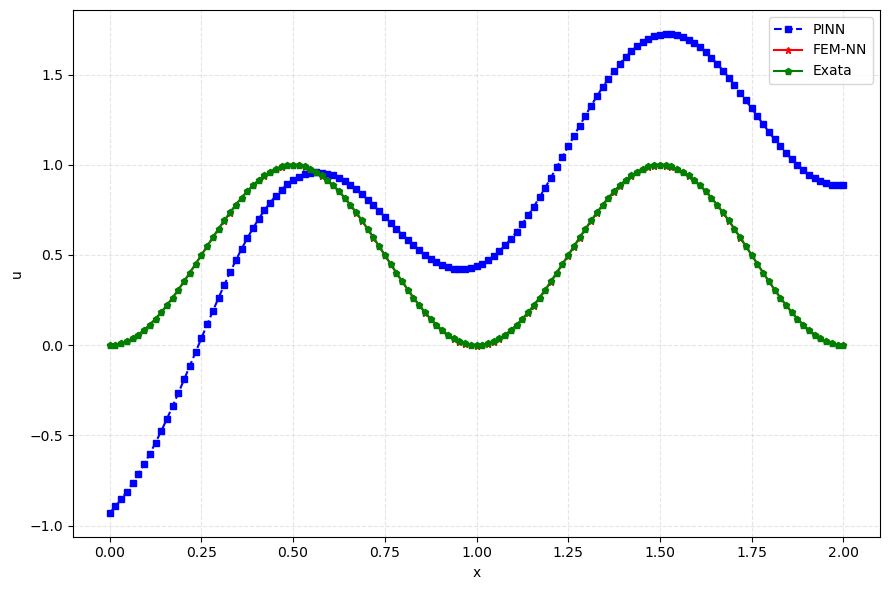

In [207]:
var1 = np.concatenate((test_in.detach().cpu().numpy(), test_out_1.detach().cpu().numpy()), axis=1)
var2 = np.concatenate((test_in.detach().cpu().numpy(), test_out_2.detach().cpu().numpy()), axis=1)
var3 = np.concatenate((test_in.detach().cpu().numpy(), u_exata), axis=1)

plot_data(var1, var2, var3, f'dataset1_simples_{epoch}', ['PINN', 'FEM-NN', 'Exata', 'x', 'u'])